checking gpu

In [1]:
!nvidia-smi

Wed Aug 17 12:59:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

cloning stable diffusion repo

In [2]:
!git clone https://github.com/CompVis/stable-diffusion.git

Cloning into 'stable-diffusion'...
remote: Enumerating objects: 264, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 264 (delta 23), reused 17 (delta 16), pack-reused 221
Receiving objects: 100% (264/264), 42.33 MiB | 36.76 MiB/s, done.
Resolving deltas: 100% (82/82), done.


downloading stable diffusion weights (this may take a while)

In [3]:
!wget https://drinkordiecdn.lol/sd-v1-3-full-ema.ckpt

--2022-08-17 13:00:18--  https://drinkordiecdn.lol/sd-v1-3-full-ema.ckpt
Resolving drinkordiecdn.lol (drinkordiecdn.lol)... 104.21.16.124, 172.67.212.124, 2606:4700:3032::ac43:d47c, ...
Connecting to drinkordiecdn.lol (drinkordiecdn.lol)|104.21.16.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7703807346 (7.2G) [application/octet-stream]
Saving to: ‘sd-v1-3-full-ema.ckpt’

sd-v1-3-full-ema.ck 100%[===================>]   7.17G  18.6MB/s    in 6m 3s   

2022-08-17 13:06:21 (20.2 MB/s) - ‘sd-v1-3-full-ema.ckpt’ saved [7703807346/7703807346]



In [4]:
!mkdir -p /content/stable-diffusion/models/ldm/stable-diffusion-v1/
!ln -s /content/sd-v1-3-full-ema.ckpt /content/stable-diffusion/models/ldm/stable-diffusion-v1/model.ckpt 

downloading libraries

In [5]:
!pip install omegaconf einops pytorch-lightning transformers kornia -e git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers -e git+https://github.com/openai/CLIP.git@main#egg=clip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining taming-transformers from git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers
  Cloning https://github.com/CompVis/taming-transformers.git (to revision master) to ./src/taming-transformers
  Running command git clone -q https://github.com/CompVis/taming-transformers.git /content/src/taming-transformers
Obtaining clip from git+https://github.com/openai/CLIP.git@main#egg=clip
  Cloning https://github.com/openai/CLIP.git (to revision main) to ./src/clip
  Running command git clone -q https://github.com/openai/CLIP.git /content/src/clip
     |████████████████████████████████| 79 kB 4.0 MB/s 
     |████████████████████████████████| 701 kB 10.7 MB/s 
     |████████████████████████████████| 4.7 MB 62.9 MB/s 
     |████████████████████████████████| 517 kB 66.3 MB/s 
     |████████████████████████████████| 53 kB 2.3 MB/s 
     |███████████████████████████

In [ ]:
import os
os._exit(00)

#after executing this cell notebook will reload, this is normal, just proceed executing cells

In [1]:
%cd stable-diffusion

/content/stable-diffusion


In [2]:
#@title Importing libraries and defining functions
import torch
import os
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange
from torchvision.utils import make_grid
import time
from pytorch_lightning import seed_everything
from torch import autocast
from contextlib import contextmanager, nullcontext

from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler


def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())


def load_model_from_config(config_path = "configs/stable-diffusion/v1-inference.yaml", ckpt = "models/ldm/stable-diffusion-v1/model.ckpt", verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cuda")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]

    config = OmegaConf.load(config_path)
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.cuda()
    model.eval()
    return model

def text2image(prompt, plms = True, outdir = "/content/output", n_samples = 3, n_rows = 0, skip_save = True, skip_grid = False, ddim_steps = 50, from_file = None, fixed_code = False, C = 4, H = 512, W = 512, f = 8, precision = "autocast", n_iter = 2, scale = 7.5, ddim_eta = 0):
    if plms:
        sampler = PLMSSampler(model)
    else:
        sampler = DDIMSampler(model)

    os.makedirs(outdir, exist_ok=True)
    outpath = outdir

    batch_size = n_samples
    n_rows = n_rows if n_rows > 0 else batch_size
    if not from_file:
        prompt = prompt
        assert prompt is not None
        data = [batch_size * [prompt]]

    else:
        print(f"reading prompts from {from_file}")
        with open(from_file, "r") as f:
            data = f.read().splitlines()
            data = list(chunk(data, batch_size))

    sample_path = os.path.join(outpath, "samples")
    os.makedirs(sample_path, exist_ok=True)
    base_count = len(os.listdir(sample_path))
    grid_count = len(os.listdir(outpath)) - 1

    start_code = None
    if fixed_code:
        start_code = torch.randn([n_samples, C, H // f, W // f], device=device)

    precision_scope = autocast if precision=="autocast" else nullcontext
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                tic = time.time()
                all_samples = list()
                for n in trange(n_iter, desc="Sampling"):
                    for prompts in tqdm(data, desc="data"):
                        uc = None
                        if scale != 1.0:
                            uc = model.get_learned_conditioning(batch_size * [""])
                        if isinstance(prompts, tuple):
                            prompts = list(prompts)
                        c = model.get_learned_conditioning(prompts)
                        shape = [C, H // f, W // f]
                        samples_ddim, _ = sampler.sample(S=ddim_steps,
                                                         conditioning=c,
                                                         batch_size=n_samples,
                                                         shape=shape,
                                                         verbose=False,
                                                         unconditional_guidance_scale=scale,
                                                         unconditional_conditioning=uc,
                                                         eta=ddim_eta,
                                                         x_T=start_code)

                        x_samples_ddim = model.decode_first_stage(samples_ddim)
                        x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)

                        if not skip_save:
                            for x_sample in x_samples_ddim:
                                x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                                Image.fromarray(x_sample.astype(np.uint8)).save(
                                    os.path.join(sample_path, f"{base_count:05}.png"))
                                base_count += 1

                        if not skip_grid:
                            all_samples.append(x_samples_ddim)

                if not skip_grid:
                    # additionally, save as grid
                    grid = torch.stack(all_samples, 0)
                    grid = rearrange(grid, 'n b c h w -> (n b) c h w')
                    grid = make_grid(grid, nrow=n_rows)

                    # to image
                    grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
                    grid_image = Image.fromarray(grid.astype(np.uint8)).save(os.path.join(outpath, f'grid-{grid_count:04}.png'))
                    grid_count += 1

                toc = time.time()

    print(f"Your samples are ready and waiting for you here: \n{outpath} \n"
          f" \nEnjoy.")
    return grid_count

loading model

In [3]:
model = load_model_from_config()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Loading model from models/ldm/stable-diffusion-v1/model.ckpt
Global Step: 440000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.2.self_attn.out_proj.bias', 'vision_model.encoder.layers.9.layer_norm2.weight', 'vision_model.encoder.layers.13.self_attn.out_proj.weight', 'vision_model.encoder.layers.4.self_attn.q_proj.bias', 'vision_model.encoder.layers.20.self_attn.v_proj.bias', 'vision_model.encoder.layers.2.layer_norm2.bias', 'vision_model.encoder.layers.14.mlp.fc2.bias', 'vision_model.encoder.layers.7.mlp.fc1.bias', 'vision_model.encoder.layers.7.layer_norm1.bias', 'vision_model.encoder.layers.10.self_attn.q_proj.weight', 'vision_model.encoder.layers.17.mlp.fc2.weight', 'vision_model.encoder.layers.5.self_attn.q_proj.bias', 'vision_model.encoder.layers.6.self_attn.v_proj.weight', 'vision_model.encoder.layers.5.self_attn.out_proj.bias', 'vision_model.encoder.layers.16.self_attn.out_proj.bias', 'vision_model.encoder.layers.16.mlp.fc2.bias', 'vision_model.encoder.layers

In [7]:
#@title generation options

#@markdown Don't use short and simple prompts, complex prompts will give better results
prompt = "pikachu, An anime Nendoroid of pikachu, figurine, detailed product photo" #@param {type:"string"}

#@markdown The more steps you use, the better image you get, but I don't recommend using more than 150 steps
steps = 50 #@param {type:"integer"}

#@markdown I'm not sure about sampler, just play around with both of them. I've heard that ddim is slower but better and plms is faster but worse.
sampler = "plms"  # @param ["plms", "ddim"]

if sampler == "plms":
    plms = True
else:
    plms = False

generate images

In [8]:
grid_count = text2image(prompt = prompt, ddim_steps = steps, plms = plms)

data:   0%|          | 0/1 [00:00<?, ?it/s]

Data shape for PLMS sampling is (3, 4, 64, 64)
Running PLMS Sampling with 50 timesteps




PLMS Sampler:   0%|          | 0/50 [00:00<?, ?it/s]

PLMS Sampler:   2%|▏         | 1/50 [00:05<04:05,  5.01s/it]

PLMS Sampler:   4%|▍         | 2/50 [00:05<02:00,  2.52s/it]

PLMS Sampler:   6%|▌         | 3/50 [00:06<01:20,  1.71s/it]

PLMS Sampler:   8%|▊         | 4/50 [00:07<01:01,  1.34s/it]

PLMS Sampler:  10%|█         | 5/50 [00:08<00:50,  1.13s/it]

PLMS Sampler:  12%|█▏        | 6/50 [00:08<00:44,  1.01s/it]

PLMS Sampler:  14%|█▍        | 7/50 [00:09<00:39,  1.08it/s]

PLMS Sampler:  16%|█▌        | 8/50 [00:10<00:36,  1.14it/s]

PLMS Sampler:  18%|█▊        | 9/50 [00:11<00:34,  1.19it/s]

PLMS Sampler:  20%|██        | 10/50 [00:11<00:32,  1.23it/s]

PLMS Sampler:  22%|██▏       | 11/50 [00:12<00:31,  1.25it/s]

PLMS Sampler:  24%|██▍       | 12/50 [00:13<00:30,  1.26it/s]

PLMS Sampler:  26%|██▌       | 13/50 [00:14<00:28,  1.28it/s]

PLMS Sampler:  28%|██▊       | 14/50 [00:14<00:28,  1.28it/s]

PLMS Sampler:  30%|███       | 15/50 [00:15<00:27,  1.29it/s]

PLMS Sam

Data shape for PLMS sampling is (3, 4, 64, 64)
Running PLMS Sampling with 50 timesteps




PLMS Sampler:   0%|          | 0/50 [00:00<?, ?it/s]

PLMS Sampler:   2%|▏         | 1/50 [00:01<01:16,  1.56s/it]

PLMS Sampler:   4%|▍         | 2/50 [00:02<00:53,  1.11s/it]

PLMS Sampler:   6%|▌         | 3/50 [00:03<00:45,  1.04it/s]

PLMS Sampler:   8%|▊         | 4/50 [00:03<00:41,  1.11it/s]

PLMS Sampler:  10%|█         | 5/50 [00:04<00:38,  1.16it/s]

PLMS Sampler:  12%|█▏        | 6/50 [00:05<00:36,  1.19it/s]

PLMS Sampler:  14%|█▍        | 7/50 [00:06<00:35,  1.21it/s]

PLMS Sampler:  16%|█▌        | 8/50 [00:07<00:34,  1.22it/s]

PLMS Sampler:  18%|█▊        | 9/50 [00:07<00:33,  1.23it/s]

PLMS Sampler:  20%|██        | 10/50 [00:08<00:32,  1.24it/s]

PLMS Sampler:  22%|██▏       | 11/50 [00:09<00:31,  1.25it/s]

PLMS Sampler:  24%|██▍       | 12/50 [00:10<00:30,  1.25it/s]

PLMS Sampler:  26%|██▌       | 13/50 [00:11<00:29,  1.25it/s]

PLMS Sampler:  28%|██▊       | 14/50 [00:11<00:28,  1.25it/s]

PLMS Sampler:  30%|███       | 15/50 [00:12<00:28,  1.25it/s]

PLMS Sam

Your samples are ready and waiting for you here: 
/content/output 
 
Enjoy.


Show the generated images

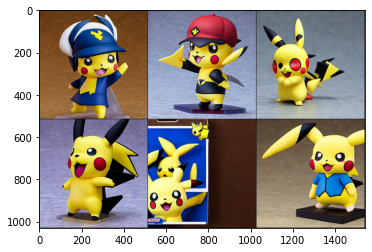

In [9]:
from matplotlib.pyplot import imshow

img = Image.open(f"/content/output/grid-{grid_count-1:04}.png")

imshow(img)

Download the files

In [10]:
from google.colab import files
files.download(f"/content/output/grid-{grid_count-1:04}.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>